In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
 
# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
 
# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

In [107]:
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\majma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\majma\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\majma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [68]:
df = pd.read_csv('Dataset/labeled_data.csv')
df.head()

,tweet,class
0,dalits are lowlives,0
1,gay people are a burden to our society,0
2,Arabs are not welcome,0
3,I'm not saying we should actually eliminate he...,0
4,bananas are for black people,0


In [69]:
class_count = df['class'].nunique()
print("Number of classes:", class_count)

Number of classes: 2


In [70]:
class_counts = df['class'].value_counts()
print(class_counts)

class
0    22262
1    18993
Name: count, dtype: int64


In [71]:
df.shape

(41255, 2)

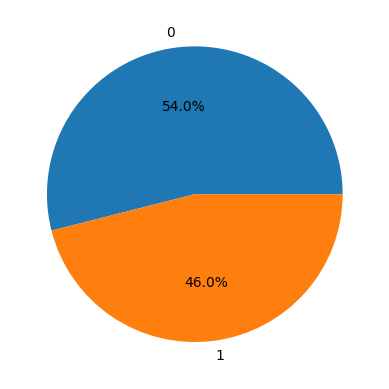

In [72]:
plt.pie(df['class'].value_counts().values,
        labels = df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [73]:
df['tweet'] = df['tweet'].str.lower()
 
# Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
#df.head()

In [74]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
 
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
 
        if word not in stop_words:
 
            # Let's Lemmatize the word as well
            # before appending to the imp_words list.
 
            lemmatizer = WordNetLemmatizer()
            lemmatizer.lemmatize(word)
 
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output

In [75]:
df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()

,tweet,class
0,dalits lowlives,0
1,gay people burden society,0
2,arabs welcome,0
3,im saying actually eliminate heebs wish natura...,0
4,bananas black people,0


In [76]:
def plot_word_cloud(data, typ):
  # Joining all the tweets to get the corpus
  email_corpus = " ".join(data['tweet'])
 
  plt.figure(figsize = (10,10))
   
  # Forming the word cloud
  wc = WordCloud(max_words = 100,
                width = 200,
                height = 100,
                collocations = False).generate(email_corpus)
   
  # Plotting the wordcloud obtained above
  plt.title(f'WordCloud for {typ} emails.', fontsize = 15)
  plt.axis('off')
  plt.imshow(wc)
  plt.show()
  print()

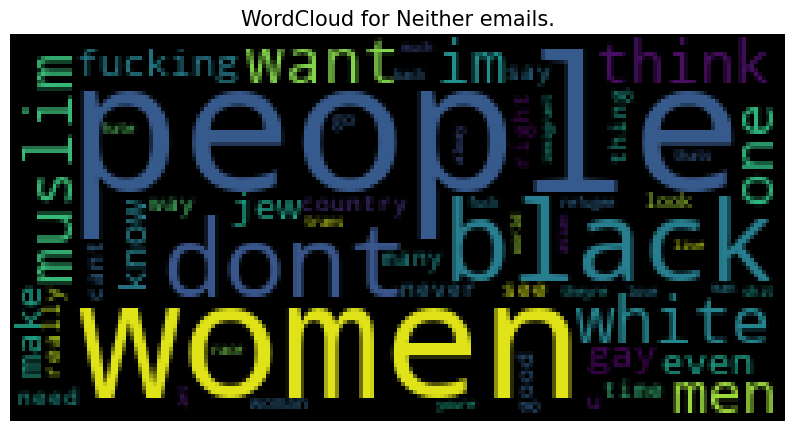

In [117]:
plot_word_cloud(df[df['class']==2], typ='Neither')

In [108]:
class_2 = df[df['class'] == 2]
class_1 = df[df['class'] == 1].sample(n=3500)
class_0 = df[df['class'] == 0]
 
balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)

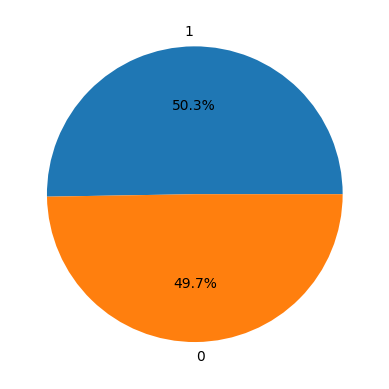

In [109]:
plt.pie(balanced_df['class'].value_counts().values,
        labels=balanced_df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [111]:
df

,tweet,class
0,dalits lowlives,0
1,gay people burden society,0
2,arabs welcome,0
3,im saying actually eliminate heebs wish natura...,0
4,bananas black people,0
...,...,...
41250,hate drags lol,1
41251,washing machine bitch,1
41252,fulham bunch losers,1
41253,k l l r n,0


In [123]:
features = balanced_df['tweet']
target = balanced_df['class']

X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=22)
X_train.shape, X_val.shape

max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)



# Convert the text data to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

# Pad the sequences
X_train = pad_sequences(X_train, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)

# Convert the target labels to categorical
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_val = tf.keras.utils.to_categorical(Y_val)

print(Y_train)

14274    0
15772    1
40781    0
30754    0
35079    0
        ..
818      0
4609     0
17705    0
13506    0
39989    0
Name: class, Length: 35809, dtype: int64


In [128]:
model = keras.models.Sequential([
    layers.Embedding(max_words, 32, input_length=max_len),
    layers.Conv1D(filters=64, kernel_size=5, activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

In [129]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 32)           160000    
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 64)            10304     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 48, 64)           0         
 1D)                                                             
                                                                 
 bidirectional_4 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 512)               16896     
                                                                 
 batch_normalization_4 (Batc  (None, 512)             

In [130]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [131]:

history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=50,
                    verbose=1,
                    batch_size=32,
                    callbacks=[lr, es])

Epoch 1/50
1120/1120 [==============================] - 21s 16ms/step - loss: 0.9234 - accuracy: 0.6433 - val_loss: 0.5761 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 2/50
1120/1120 [==============================] - 17s 15ms/step - loss: 0.4589 - accuracy: 0.8090 - val_loss: 0.5135 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 3/50
1120/1120 [==============================] - 17s 15ms/step - loss: 0.3017 - accuracy: 0.8950 - val_loss: 0.4643 - val_accuracy: 0.8240 - lr: 0.0010
Epoch 4/50
1120/1120 [==============================] - 17s 15ms/step - loss: 0.2154 - accuracy: 0.9342 - val_loss: 0.4314 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 5/50
1120/1120 [==============================] - 17s 15ms/step - loss: 0.1751 - accuracy: 0.9514 - val_loss: 0.7161 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 6/50
1120/1120 [==============================] - 17s 15ms/step - loss: 0.1484 - accuracy: 0.9612 - val_loss: 0.5048 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 7/50
1120/1120 [========================

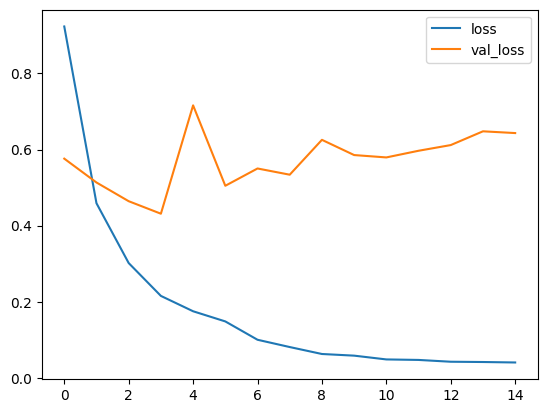

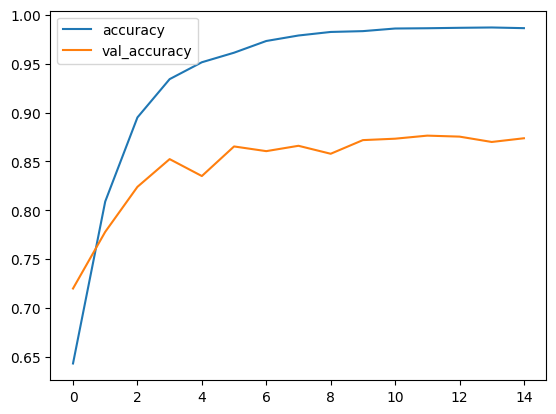

In [132]:

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [133]:
history_df.loc[:, ['loss', 'val_loss']]

,loss,val_loss
0,0.923403,0.576105
1,0.458925,0.513452
2,0.301748,0.464291
3,0.215448,0.431417
4,0.175101,0.716140
5,0.148400,0.504824
6,0.100214,0.550260
7,0.081071,0.533926
8,0.062803,0.625535
9,0.058468,0.585538


In [134]:
history_df.loc[:, ['accuracy', 'val_accuracy']]

,accuracy,val_accuracy
0,0.643302,0.719982
1,0.808987,0.777952
2,0.894971,0.823970
3,0.934151,0.852340
4,0.951409,0.835027
5,0.961183,0.865297
6,0.973163,0.860494
7,0.978776,0.865967
8,0.982407,0.857813
9,0.983244,0.871775


In [135]:
# Save the trained model
model.save("data/hate_speech_detection_model5.h5")

In [167]:
def classify_message(message):
    # Preprocess the message
    message = message.lower()
    message = remove_punctuations(message)
    message = remove_stopwords(message)

    # Tokenize and pad the message
    tokenized_message = tokenizer.texts_to_sequences([message])
    padded_message = pad_sequences(tokenized_message, maxlen=100)

    # Make predictions
    predictions = model.predict(padded_message)
    predicted_class = np.argmax(predictions)

    # Map the predicted class to the corresponding label
    label_mapping = label_mapping = {0: 'Hate Speech', 1: 'Abusive', 2: 'Neutral'}
    predicted_label = label_mapping[predicted_class]

    return predicted_label, predicted_class


In [173]:
inp = "Let’s Kill Jews, and let’s kill them for fun. #killjews"
print(classify_message(inp))


1/1 [==============================] - 0s 24ms/step
('Non Hate Speech', 0.0)
